*Note: all those exercises should be done using python with pyccel openmp*

## Exercise 1 Hello World

1. Write an OpenMP program displaying the number of threads used for the execution and the rank of each of the threads.
3. Test the programs obtained with different numbers of threads for the parallel program.

**Output Example**
```shell
>> Python hello.py
Hello from the rank 2 thread
Hello from the rank 0 thread
Hello from the rank 3 thread
Hello from the rank 1 thread
Hello from the rank 4 thread
Parallel execution of hello_world with 4 threads
```
*Note that the output order maybe different*

In [1]:
%%file hello.py
# write your program here

if __name__ == "__main__":
    from pyccel.stdlib.internal.openmp import omp_get_num_threads, omp_get_thread_num
    
    #$omp parallel
    rank = omp_get_thread_num()
    total = omp_get_num_threads()
    print("Hello from the rank", rank, "thread")
    #$omp end parallel
    print("Parallel execution of hello_world with", total , "threads")

Overwriting hello.py


In [2]:
# enter command for compile and run the program
!pyccel --language=c hello.py --openmp
!./hello

Hello from the rank 0 thread
Hello from the rank 2 thread
Hello from the rank 1 thread
Hello from the rank 3 thread
Parallel execution of hello_world with 4 threads


In [3]:
import os
for num_threads in ["2", "4", "6", "8"]:
    os.environ["OMP_NUM_THREADS"] = num_threads
    !./hello
    print("\n")

Hello from the rank 0 thread
Hello from the rank 1 thread
Parallel execution of hello_world with 2 threads


Hello from the rank 1 thread
Hello from the rank 2 thread
Hello from the rank 0 thread
Hello from the rank 3 thread
Parallel execution of hello_world with 4 threads


Hello from the rank 0 thread
Hello from the rank 2 thread
Hello from the rank 1 thread
Hello from the rank 3 thread
Hello from the rank 4 thread
Hello from the rank 5 thread
Parallel execution of hello_world with 6 threads


Hello from the rank 6 thread
Hello from the rank 4 thread
Hello from the rank 3 thread
Hello from the rank 7 thread
Hello from the rank 5 thread
Hello from the rank 2 thread
Hello from the rank 0 thread
Hello from the rank 1 thread
Parallel execution of hello_world with 8 threads




## Exercise 2 Matrix product

Considering the following code for matrix product:

1. Using pyccel, epyccelize the `matrix_prod` function, and time the execution of epyccelized function.
2. Insert the appropriate OpenMP directives and analyse the code performance.
3. Test the loop iteration repartition modes (`STATIC`, `DYNAMIC`, `GUIDED`) and vary the chunk sizes.
**Example output**

```bash
   Value of M and N           : 20 20 
    Temps elapsed              : 0.0009012222290039062 
    Temps CPU                  : 0.0 
    Partiel results            : 2790.0 2690.0 ... -3610.0 -4350.0 

 Execution of Matrix production in parallele with                     8 threads
```

### 1.1. matrix_prod not epyccelized performance

In [4]:
def matrix_prod(A, B, C, N, M):
    for i in range( M ):
        for j in range( N ):
            A[i, j] = (i + 1) + (j + 1)

    for i in range( N ):
        for j in range( M ):
            B[i, j] = (i + 1) - (j + 1)

    
    for i in range( M ):
        for j in range( M ):
            C[i, j] = 0

    # Matrix Production
    
    for i in range( M ):
        for j in range( M ):
            for k in range( N ):
                C[i, j] += A[i, k] * B[k,j]

    
#print("Execution of Matrix production in parallele with",nb_threads, "threads")


if __name__ == "__main__":
    import numpy as np
    import time
    import math

    M = 100
    N = 100
    # Declare Matrices
    A = np.empty((M, N), dtype=np.double)
    B = np.empty((N, M), dtype=np.double)
    C = np.empty((M, M), dtype=np.double)

    #  run and time the matrix_prod function
    # start CPU timing
    cpu_start_time = time.process_time()

    # start Wall timing
    elapsed_start_time = time.time()

    # -------------------- computing ------------------
    matrix_prod(A, B, C, N, M)
    # ------------------ End computing ----------------
    
    cpu_end_time = time.process_time()
    elapsed_end_time = time.time()
    
    # CPU time
    cpu = cpu_end_time - cpu_start_time
    
    # Wall timing
    
    elapsed = elapsed_end_time - elapsed_start_time
    
    print("Value of M and N           : ", M, N)
    print("Temps elapsed              : ", elapsed)
    print("Temps CPU                  : ", cpu)
    print("Partiel results            : ", C[0, :10]) # Printing first 10 values of the first row.

Value of M and N           :  100 100
Temps elapsed              :  1.0071015357971191
Temps CPU                  :  0.9984875169999996
Partiel results            :  [338250. 333100. 327950. 322800. 317650. 312500. 307350. 302200. 297050.
 291900.]


In [5]:
%timeit matrix_prod

20.8 ns ± 0.475 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


### 1.2. matrix_prod epyccelized performance

In [6]:
def matrix_prod_py(A : 'float[:,:]', B :'float[:,:]', C : 'float[:,:]', N: 'int', M: 'int'):
    
    for i in range( M ):
        for j in range( N ):
            A[ i, j ] = (i + 1) + (j + 1)

    
    for i in range( N ):
        for j in range( M ):
            B[ i, j ] = (i + 1) - (j + 1)

    
    for i in range( M ):
        for j in range( M ):
            C[ i, j ] = 0
            

    # Matrix Production
    
    for i in range( M ):
        for j in range( M ):
            for k in range( N ):
                C[ i, j ] += A[ i, k ] * B[ k, j ]

if __name__ == "__main__":
    import numpy as np
    import time
    import math

    M = 100
    N = 100

    # Declare Matrices
    A = np.empty((M, N), dtype=np.double)
    B = np.empty((N, M), dtype=np.double)
    C = np.empty((M, M), dtype=np.double)

    #  run and time the matrix_prod function
    # start CPU timing
    cpu_start_time = time.process_time()

    # start Wall timing
    elapsed_start_time = time.time()

    # Pyccelize matrix_prod function
    from pyccel.epyccel import epyccel
    matrix_prod_pyccel = epyccel(matrix_prod_py, language='c', accelerators=['openmp'])
    
    # -------------------- computing ------------------
    matrix_prod_pyccel(A, B, C, N, M)
    
    cpu_end_time = time.process_time()
    elapsed_end_time = time.time()
    
    # CPU time
    cpu = cpu_end_time - cpu_start_time

    # Wall timing
    elapsed = elapsed_end_time - elapsed_start_time
    
    print("Value of M and N           : ", M, N)
    print("Temps elapsed              : ", elapsed)
    print("Temps CPU                  : ", cpu)
    print("Partiel results            : ", C[0, :10]) # Printing first 10 values of the first row.

Value of M and N           :  100 100
Temps elapsed              :  1.140481948852539
Temps CPU                  :  0.5549125989999979
Partiel results            :  [338250. 333100. 327950. 322800. 317650. 312500. 307350. 302200. 297050.
 291900.]


In [7]:
%timeit matrix_prod_py

20.6 ns ± 1.61 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


### 2. matrix_prod with OpenMP directives epyccelized performance

In [8]:
def matrix_prod_with_openmp(A:'float[:,:]', B:'float[:,:]', C:'float[:,:]', N:'int', M:'int', nb_threads:'int'):
    
    """
    if there is a n consecutive for loops (nested loops) , we will add collapse(n).
    We will also reduce some operators applied on like +, * in our case.
    """
    
    #$ omp parallel num_threads(nb_threads)
    #$ omp for collapse(2) nowait
    for i in range( M ):
        for j in range( N ):
            A[ i, j ] = (i + 1) + (j + 1)

    #$ omp for collapse(2) nowait
    for i in range( N ):
        for j in range( M ):
            B[ i, j ] = (i + 1) - (j + 1)

    #$ omp for collapse(2)
    for i in range( M ):
        for j in range( M ):
            C[ i, j ] = 0

    # Matrix Production
    #$ omp for collapse(3)
    for i in range( M ):
        for j in range( M ):
            for k in range( N ):
                C[ i, j ] += A[ i, k ] * B[ k, j ]
    #$ omp end parallel
    print("Execution of Matrix production in parallele with",nb_threads, "threads")
    
if __name__ == "__main__":
    import numpy as np
    import time
    import math

    M = 100
    N = 100

    # Declare Matrices
    A = np.empty((M, N), dtype=np.double)
    B = np.empty((N, M), dtype=np.double)
    C = np.empty((M, M), dtype=np.double)

    #  run and time the matrix_prod function
    # start CPU timing
    cpu_start_time = time.process_time()

    # start Wall timing
    elapsed_start_time = time.time()

    # Pyccelize matrix_prod function
    from pyccel.epyccel import epyccel
    matrix_prod_openmp_pyccel = epyccel(matrix_prod_with_openmp, language='c', accelerators=['openmp'])
    
    # -------------------- computing ------------------
    nb_threads = 4 # setting the number of threads to use
    matrix_prod_openmp_pyccel(A, B, C, N, M, nb_threads)
    # ------------------ End computing ----------------
    
    cpu_end_time = time.process_time()
    elapsed_end_time = time.time()
    
    # CPU time
    cpu = cpu_end_time - cpu_start_time

    # Wall timing
    elapsed = elapsed_end_time - elapsed_start_time
    
    print("Value of M and N           : ", M, N)
    print("Temps elapsed              : ", elapsed)
    print("Temps CPU                  : ", cpu)
    print("Partiel results            : ", C[0, :10]) # Printing first 10 values of the first row.
    print("Execution of Matrix production in parallele with",nb_threads, "threads")

Value of M and N           :  100 100
Temps elapsed              :  0.71468186378479
Temps CPU                  :  0.12987260899999953
Partiel results            :  [338250. 333100. 327950. 322800. 317650. 312500. 307350. 302200. 297050.
 291900.]
Execution of Matrix production in parallele with 4 threads


### 3. Variation of number of threads (performance comparison)

In [9]:
# Let's import some useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

,cpu time with openmp,elapsed time with openmp,cpu time without openmp,elapsed time without openmp
threads,,,,
1.0,0.002171,0.002168,0.819299,0.819110
2.0,0.001885,0.001153,0.816359,0.816446
3.0,0.001524,0.001521,0.765436,0.765598
4.0,0.001198,0.001196,0.805114,0.779707
5.0,0.004183,0.001464,0.837660,0.801072
6.0,0.004605,0.001599,0.785603,0.785638
7.0,0.003802,0.001414,0.778970,0.778969


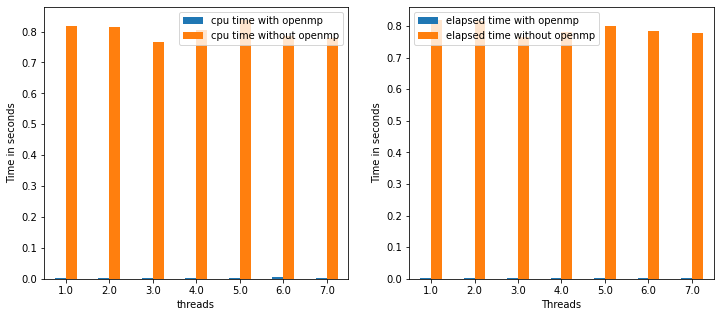

In [10]:
# Let's create dataframe which will contain results based on number of threads
results_df = pd.DataFrame(columns=["threads", "cpu time with openmp", "elapsed time with openmp", "cpu time without openmp", "elapsed time without openmp"])


for thread in range(1, 8):
    
    cpu_start_time = time.process_time()
    elapsed_start_time = time.time()

    matrix_prod(A, B, C, N, M)

    cpu_end_time = time.process_time()
    elapsed_end_time = time.time()

    cpu_without_openmp = cpu_end_time - cpu_start_time
    elapsed_without_openmp = elapsed_end_time - elapsed_start_time

    matrix_prod_openmp_pyccel = epyccel(matrix_prod_with_openmp, language='c', accelerators=['openmp'])
    cpu_start_time = time.process_time()
    elapsed_start_time = time.time()
    
    matrix_prod_openmp_pyccel(A, B, C, N, M, thread)
    
    cpu_end_time = time.process_time()
    elapsed_end_time = time.time()
    
    index = len(results_df)
    results_df.loc[index] = [thread, cpu_end_time - cpu_start_time, elapsed_end_time - elapsed_start_time, cpu_without_openmp, elapsed_without_openmp]


print(" ")
results_df.set_index('threads', inplace=True)

# Let's plot results
display(results_df)

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
results_df[["cpu time with openmp", "cpu time without openmp"]].plot.bar(rot=0, ax=ax)
results_df[["elapsed time with openmp", "elapsed time without openmp"]].plot.bar(rot=0, ax=ax2)

plt.xlabel("Threads")
ax.set_ylabel("Time in seconds")
ax2.set_ylabel("Time in seconds")

plt.legend()

By adding OpenMP directives, we can see that there is an performance improvement in terms of time (CPU and Elapsed) compared to the iniatial one. So, OpenMP has a big effect on code performance.

## Exercise 3 Jacobi method

Considering the following code for a general linear system solver:

$$ A \times x = b $$

using the Jacobi iterative method.
In this exercice, you must solve the system in parallel
   
**Example Output**
    
```bash
System size    : 20 
 Iterations     : 21 
 Stand          : 2.9100049961372497e-08 
 Elapsed Time   : 7.447303771972656 
 CPU time       : 0.921875 
```

### Without OpenMP directives

In [11]:
def jacobi(a : 'float[:,:]', b : 'float[:]', x : 'float[:]', n :'int', eps: 'float'):
    #print("Execution of Jacobi in parallel with", nb_tasks, "threads")
    # Jacobi method resolution
    import numpy as np
    import math
    x_courant = np.empty(n, dtype=np.double)
    iteration = 0
    while(1):
        iteration += 1

        for i in range(n):
            x_courant[i] = 0
            for j in range(i):
                x_courant[i] += a[ j, i ] * x[j]

            for j in range(i + 1, n):
                x_courant[i] += a[ j, i ] * x[j]

            x_courant[i] = (b[i] - x_courant[i]) / a[ i, i ]

        # Convergence test
        absmax = 0.
        for i in range(n):
            curr = math.fabs(x[i] - x_courant[i])
            if curr > absmax:
                absmax = curr
        stand = absmax / n
        if stand <= eps or iteration > n:
            break

        # copy x_courant into x
        for i in range(n):
            x [i] = x_courant[i]
    return stand, iteration


if __name__ == "__main__":

    import numpy as np
    import time, random, math, sys

    # Matrix default dimension
    n = 20
    diag = 20

    # Initialize of the matrices
    np.random.seed(421)  # for reproductibles results
    a = np.random.uniform(0, 1, size=(n, n))
    b = np.random.uniform(0, 1, size=n)

    # We strengthen the main diagonal of the matrix
    for i in range(n):
        a[i, i] += diag

    # Initial solution
    x = np.ones(n, dtype=np.double)

    # start CPU timing
    cpu_0 = time.process_time()

    # start Wall timing
    elapsed_0 = time.time()

    # Pyccelize jacobi function
    from pyccel.epyccel import epyccel
    jacobi_pyccel = epyccel(jacobi, language='c', accelerators=['openmp'])

    eps = sys.float_info.epsilon

    # -------------------- computing ------------------
    stand, iteration = jacobi_pyccel(a, b, x, n, eps)
    # ------------------ End computing ----------------

    # CPU time
    cpu_1 = time.process_time()
    cpu = cpu_1 - cpu_0

    # Wall timing
    elapsed_1 = time.time()
    elapsed = elapsed_1 - elapsed_0

    print(
        "\n",
        "System size    :", n,          '\n',
        "Iterations     :", iteration,  '\n',
        "Stand          :", stand,      '\n',
        "Elapsed Time   :", elapsed,    '\n',
        "CPU time       :", cpu,        '\n'
    )


 System size    : 20 
 Iterations     : 21 
 Stand          : 2.9100049961372497e-08 
 Elapsed Time   : 0.5278184413909912 
 CPU time       : 0.05613368999999935 



### With OpenMP directives

In [12]:
def jacobi_with_openmp(a : 'float[:,:]', b : 'float[:]', x : 'float[:]', n :'int', eps: 'float', nb_tasks: 'int'):
    print("Execution of Jacobi in parallel with", nb_tasks, "threads")
    
    # Jacobi method resolution
    import numpy as np
    import math
    x_courant = np.empty(n, dtype=np.double)
    iteration = 0
    
    """
    if there is a n consecutive for loops (nested loops), we will add collapse(n).
    We will also reduce some operators applied on like +, * in our case.
    """
    
    #$ omp parallel num_threads(nb_tasks)
    while(1):
        iteration += 1
        
        #$ omp for
        for i in range(n):
            x_courant[i] = 0
            
            for j in range(i):
                x_courant[i] += a[ j, i ] * x[j]

            for j in range(i + 1, n):
                x_courant[i] += a[ j, i ] * x[j]

            x_courant[i] = (b[i] - x_courant[i]) / a[ i, i ]

        # Convergence test
        absmax = 0.
        
        #$ omp for
        for i in range(n):
            curr = math.fabs(x[i] - x_courant[i])
            if curr > absmax:
                absmax = curr
                
        stand = absmax / n
        if stand <= eps or iteration > n:
            break

        # copy x_courant into x
        
        #$ omp for
        for i in range(n):
            x [i] = x_courant[i]
    
    #$ omp end parallel
    return stand, iteration


if __name__ == "__main__":

    import numpy as np
    import time, random, math, sys

    # Matrix default dimension
    n = 20
    diag = 20

    # Initialize of the matrices
    np.random.seed(421)  # for reproductibles results
    a = np.random.uniform(0, 1, size=(n, n))
    b = np.random.uniform(0, 1, size=n)

    # We strengthen the main diagonal of the matrix
    for i in range(n):
        a[i, i] += diag

    # Initial solution
    x = np.ones(n, dtype=np.double)

    # start CPU timing
    cpu_0 = time.process_time()

    # start Wall timing
    elapsed_0 = time.time()

    # Pyccelize jacobi function
    from pyccel.epyccel import epyccel
    jacobi_openmp_pyccel = epyccel(jacobi_with_openmp, language='c', accelerators=['openmp'])

    eps = sys.float_info.epsilon

    # -------------------- computing ------------------
    nb_tasks = 6
    stand, iteration = jacobi_openmp_pyccel(a, b, x, n, eps, nb_tasks)

    # ------------------ End computing ----------------

    # CPU time
    cpu_1 = time.process_time()
    cpu = cpu_1 - cpu_0

    # Wall timing
    elapsed_1 = time.time()
    elapsed = elapsed_1 - elapsed_0

    print(
        "\n",
        "System size    :", n,          '\n',
        "Iterations     :", iteration,  '\n',
        "Stand          :", stand,      '\n',
        "Elapsed Time   :", elapsed,    '\n',
        "CPU time       :", cpu,        '\n'
    )


 System size    : 20 
 Iterations     : 24 
 Stand          : 0.009600046484838351 
 Elapsed Time   : 0.32302117347717285 
 CPU time       : 0.06312719299999969 



### Comparison

,cpu time with openmp,elapsed time with openmp,cpu time without openmp,elapsed time without openmp
threads,,,,
1.0,0.000083,0.000078,0.053808,0.276513
2.0,0.000279,0.000119,0.042004,0.263002
3.0,0.000137,0.000132,0.056253,0.290554
4.0,0.009661,0.003336,0.066250,0.262125
5.0,0.000420,0.000242,0.134127,0.490621
6.0,0.000469,0.000244,0.070250,0.431444
7.0,0.000650,0.000337,0.046829,0.321954


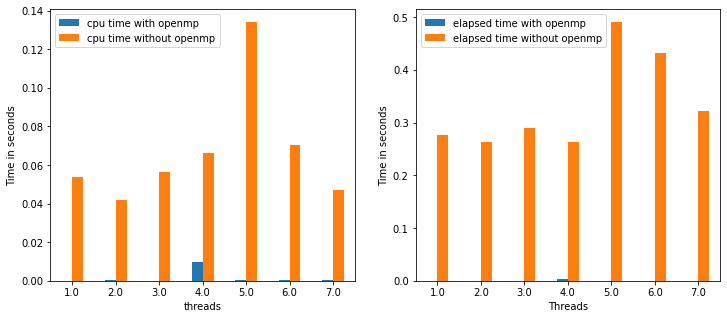

In [13]:
# Let's create dataframe which will contain results based on number of threads
results_df = pd.DataFrame(columns=["threads", "cpu time with openmp", "elapsed time with openmp", "cpu time without openmp", "elapsed time without openmp"])


for thread in range(1, 8):
    cpu_start_time = time.process_time()
    elapsed_start_time = time.time()

    jacobi_pyccel = epyccel(jacobi, language='c', accelerators=['openmp'])
    stand, iteration = jacobi_pyccel(a, b, x, n, eps)

    cpu_end_time = time.process_time()
    elapsed_end_time = time.time()

    cpu_without_openmp = cpu_end_time - cpu_start_time
    elapsed_without_openmp = elapsed_end_time - elapsed_start_time

    jacobi_pyccel = epyccel(jacobi, language='c', accelerators=['openmp'])
    cpu_start_time = time.process_time()
    elapsed_start_time = time.time()
    
    stand, iteration = jacobi_openmp_pyccel(a, b, x, n, eps, thread)
    
    cpu_end_time = time.process_time()
    elapsed_end_time = time.time()
    
    index = len(results_df)
    results_df.loc[index] = [thread, cpu_end_time - cpu_start_time, elapsed_end_time - elapsed_start_time, cpu_without_openmp, elapsed_without_openmp]


print(" ")
results_df.set_index('threads', inplace=True)

# Let's plot results
display(results_df)

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
results_df[["cpu time with openmp", "cpu time without openmp"]].plot.bar(rot=0, ax=ax)
results_df[["elapsed time with openmp", "elapsed time without openmp"]].plot.bar(rot=0, ax=ax2)

plt.xlabel("Threads")
ax.set_ylabel("Time in seconds")
ax2.set_ylabel("Time in seconds")

plt.legend()

## Exercise 4 Calculation of π

The aim of this exercise is to calculate π by numerical integration knowing that Considering the following code for matrix product: $\int_{0}^{1} \frac{4}{1 + x^2} = {\pi} $

The following program is for calculating the value of
π by the rectangle method (mid-point). Let $f(x) = \frac{4}{1 + x^2} $
2 be the function to integrate, N and $ h = \frac{1}{N} $ (respectively) the number of points, and the discretization width on the integration
interval $[0, 1]$.

Analyse the performance of the codes, then optimise  your code using OpenMP directives.

In [14]:
%%file pi.py
def f(a: 'float'):
    return 4.0 / (1. + a * a)


def pi(n: 'int', h: 'float'):
    for k in range(100):
        Pi_calc = 0.
        for i in range(n):
            x = h * (i + 0.5)
            Pi_calc += f(x)

        Pi_calc = h * Pi_calc
    
    return Pi_calc

def pi_openmp(n : 'int', h: 'float', nb_tasks: 'int'):
    print("Execution of PI in parallel with", nb_tasks,"threads")
    
    #$ omp parallel num_threads(nb_tasks)
    
    #$ omp for firstprivate(Pi_calc)
    for k in range(100):
        Pi_calc = 0.
        for i in range(n):
            x = h * (i + 0.5)
            #$ omp critical
            Pi_calc += f(x)
            #$ omp end critical

        Pi_calc = h * Pi_calc
    #$ omp end parallel
    
    return Pi_calc

Overwriting pi.py


In [15]:
import time, math

if __name__ == '__main__':
    #                  __
    #  But : calcul de || par la methode des rectangles (point milieu).
    #
    #                   / 1
    #                  |       4            __
    #                  |   ----------  dx = ||
    #                  |    1 + x**2
    #                 / 0


    n = 300

    # Length of the integration interval
    h = 1.0 / n

    from pyccel.epyccel import epyccel
    import pi
    pyc_pi = epyccel(pi, language='c', accelerators=['openmp'])

    # start timing
    tcpu_0 = time.process_time() # CPU time
    t_elapsed_0 = time.time()    # Wall time

    # -------------------- computing ------------------
    nb_tasks = 4
    Pi_calc = pyc_pi.pi_openmp(n, h, nb_tasks)

    # ------------------ End computing ----------------

    # CPU time spent
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0

    # Wall time spent
    t_elapsed_1 = time.time()
    t_elapsed = t_elapsed_1 - t_elapsed_0

    # deviation between the estimated value and the calculated value of Pi
    Pi_estime = math.acos(-1)
    deviat = math.fabs(Pi_estime - Pi_calc)

    # Print result
    print(
      "\n"
      "  Number of intervals        :", n,         "\n",
      "| Pi_estime - Pi_calcule | :", deviat,    "\n",
      "Temps elapsed              :", t_elapsed, "\n",
      "Temps CPU                  :", tcpu,      "\n",
    )


  Number of intervals        : 300 
 | Pi_estime - Pi_calcule | : 3.141592653589793 
 Temps elapsed              : 0.0018262863159179688 
 Temps CPU                  : 0.004924094999999795 



### Comparison

,cpu time with openmp,elapsed time with openmp,cpu time without openmp,elapsed time without openmp
threads,,,,
1.0,0.000520,0.000517,0.014937,0.015121
2.0,0.000917,0.000737,0.005377,0.005374
3.0,0.016002,0.009708,0.009418,0.005416
4.0,0.005734,0.001844,0.038098,0.014482
5.0,0.006251,0.001685,0.031098,0.007111
6.0,0.005197,0.001515,0.005387,0.005386
7.0,0.005793,0.001682,0.005413,0.005411


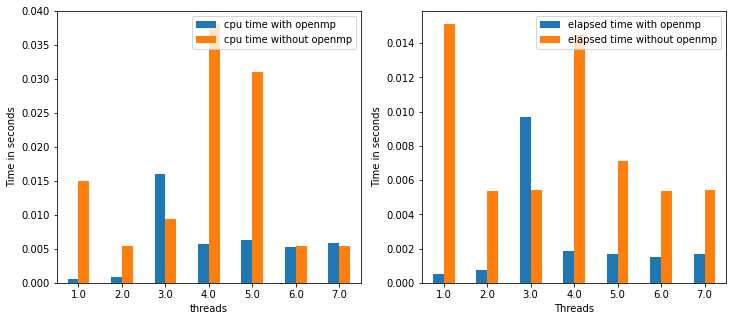

In [16]:
# Let's create dataframe which will contain results based on number of threads
results_df = pd.DataFrame(columns=["threads", "cpu time with openmp", "elapsed time with openmp", "cpu time without openmp", "elapsed time without openmp"])

n = 300
h = 1./n
import pi
for thread in range(1, 8):

    cpu_start_time = time.process_time()
    elapsed_start_time = time.time()

    Pi_calc = pi.pi(n, h)

    cpu_end_time = time.process_time()
    elapsed_end_time = time.time()

    cpu_without_openmp = cpu_end_time - cpu_start_time
    elapsed_without_openmp = elapsed_end_time - elapsed_start_time

    pyc_pi = epyccel(pi, language='c', accelerators=['openmp'])
    
    cpu_start_time = time.process_time()
    elapsed_start_time = time.time()
    
    Pi_calc = pyc_pi.pi_openmp(n, h, thread)
    
    cpu_end_time = time.process_time()
    elapsed_end_time = time.time()
    
    index = len(results_df)
    results_df.loc[index] = [thread, cpu_end_time - cpu_start_time, elapsed_end_time - elapsed_start_time, cpu_without_openmp, elapsed_without_openmp]


print(" ")
results_df.set_index('threads', inplace=True)

# Let's plot results
display(results_df)

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
results_df[["cpu time with openmp", "cpu time without openmp"]].plot.bar(rot=0, ax=ax)
results_df[["elapsed time with openmp", "elapsed time without openmp"]].plot.bar(rot=0, ax=ax2)

plt.xlabel("Threads")
ax.set_ylabel("Time in seconds")
ax2.set_ylabel("Time in seconds")

plt.legend()

## Exercise 5 Reduction of an array

The given program contained in the `reduction_tab.py` file is extracted from a chemistry code. It reduces a three-dimensional array into a vector. The aim of this exercise is to parallelize this calculation kernel without changing the loop order in the provided code (i.e. k,j,i)

1. Analyse the data-sharing attributes of the variables and adapt the source code so that the K outermost loop is parallelized.
2. Compare the performance obtained by using the thread/core binding default execution on Ada and by using scatter binding. Suggest an explanation for the poor performance of the latter.
3. Optimise the source code for the scatter mode with taking into account the memory affinity. Why does this third series of executions give the best performance 

In [17]:
%%file reduction_tab.py

def threads_num():
    
    # complete this function for getting threads num
    from pyccel.stdlib.internal.openmp import omp_get_num_threads
    return omp_get_num_threads()

def initialize_table(tab: 'float[:, :, :]', nmolec: 'int', n: 'int', nmol:'int'):
    # Initialisation du tableau
    # First-touch pour garantir un fonctionnement optimal sur les systemes NUMA
    
    for k in range(nmolec):
        for j in range(n):
            for i in range(nmol):
                tab[ i,j,k ] = i + j + k
    

def initialize_table_openmp(tab: 'float[:, :, :]', nmolec: 'int', n: 'int', nmol:'int'):
    # Initialisation du tableau
    # First-touch pour garantir un fonctionnement optimal sur les systemes NUMA
    
    #$ omp parallel 
    #$ omp for collapse(3)
    for k in range(nmolec):
        for j in range(n):
            for i in range(nmol):
                tab[ i,j,k ] = i + j + k
    #$ omp end parallel
    
def reduction(tab: 'float[:, :, :]', tab1: 'float[:]', tab2: 'float[:]', nmolec: 'int' , nmol: 'int', n: 'int'):
    
    for k in range(nmolec):
        tab1[:nmol] = 0
        
        for j in range(n):
            for i in range(nmol):
                tab1[i] = tab1[i] + tab[i,j,k]
        tab2[:nmol] = tab2[:nmol] + 2 * tab1[:nmol]
    

def reduction_openmp(tab: 'float[:, :, :]', tab1: 'float[:]', tab2: 'float[:]', nmolec: 'int' , nmol: 'int', n: 'int'):
    
    #$ omp parallel
    #$ omp for reduction(+:tab2) reduction(+:tab1)
    for k in range(nmolec):
        tab1[:nmol] = 0
        
        for j in range(n):
            for i in range(nmol):
                tab1[i] = tab1[i] + tab[i,j,k]
        tab2[:nmol] = tab2[:nmol] + 2 * tab1[:nmol]
    #$ omp end parallel

Overwriting reduction_tab.py


In [18]:
from os import error

if __name__ == '__main__':
    import numpy as np
    import time
    from pyccel.stdlib.internal.openmp import omp_set_num_threads
    
    # default dimension
    nmolec = 100
    nmol   = 100
    n      = 10

    tab     = np.empty((nmol, n, nmolec), dtype=np.double)
    tab1    = np.empty((nmol), dtype=np.double)
    tab2    = np.zeros((nmol), dtype=np.double)

    # pyccelize reduction tab module
    from pyccel.epyccel import epyccel
    import reduction_tab
    
    reduction = epyccel(reduction_tab, language='fortran', accelerators=['openmp'])
    
    print("Execution of reduction table in parallele with", reduction.threads_num(), "threads")

    # initialize tab 
    reduction.initialize_table_openmp(tab, nmol, n, nmolec)

    # start timing
    tcpu_0 = time.process_time() # CPU time
    t_elapsed_0 = time.time()    # Wall time

    # -------------------- computing ------------------
    reduction.reduction_openmp(tab, tab1, tab2, nmolec, nmol, n)
    # ------------------ End computing ----------------

    # CPU time spent
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0

    # Wall time spent
    t_elapsed_1 = time.time()
    t_elapsed = t_elapsed_1 - t_elapsed_0

    # verification of results
    tab2c = np.zeros((nmol), dtype=np.double)
    for k in range(nmolec):
        tab1c = np.zeros((nmol), dtype=np.double)
        for j in range(n):
            for i in range(nmol):
                tab1c[i] = tab1c[i] + tab[i, j, k]
        tab2c [:] = tab2c[:nmol] + 2 * tab1c[:]
    err = np.max(np.abs(tab2c - tab2) / np.abs(tab2c))
    print(
        "Temps elapsed  :", t_elapsed   , "\n",
        "Temps CPU      :", tcpu        , "\n",
        "Erreur relative:", err         , "\n"
    )

Execution of reduction table in parallele with 1 threads
Temps elapsed  : 0.00031113624572753906 
 Temps CPU      : 0.000543776000000662 
 Erreur relative: 0.0 



### Comparison

,cpu time with openmp,elapsed time with openmp,cpu time without openmp,elapsed time without openmp
threads,,,,
1.0,0.001981,0.000644,0.081658,0.077781
2.0,0.001731,0.000614,0.103235,0.104723
3.0,0.001711,0.000552,0.062005,0.062029
4.0,0.003196,0.002061,0.061750,0.061750
5.0,0.001741,0.000562,0.114831,0.114871
6.0,0.001992,0.000677,0.060030,0.060052
7.0,0.001720,0.000743,0.103903,0.103941


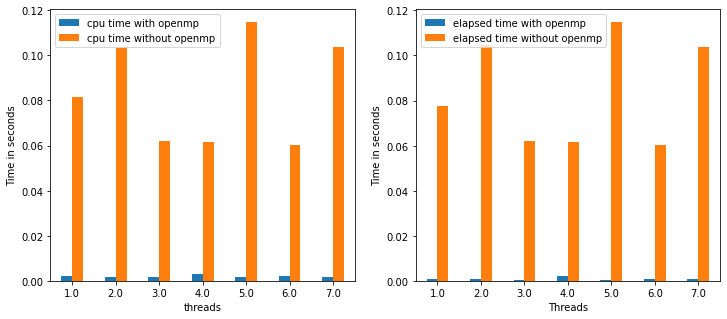

In [19]:
# Let's create dataframe which will contain results based on number of threads
results_df = pd.DataFrame(columns=["threads", "cpu time with openmp", "elapsed time with openmp", "cpu time without openmp", "elapsed time without openmp"])

from pyccel.stdlib.internal.openmp import omp_set_num_threads
import reduction_tab

for thread in range(1, 8):
    
    cpu_start_time = time.process_time()
    elapsed_start_time = time.time()
    omp_set_num_threads(thread)
    reduction_tab.initialize_table(tab, nmol, n, nmolec)
    reduction_tab.reduction(tab, tab1, tab2, nmolec, nmol, n)

    cpu_end_time = time.process_time()
    elapsed_end_time = time.time()

    cpu_without_openmp = cpu_end_time - cpu_start_time
    elapsed_without_openmp = elapsed_end_time - elapsed_start_time
    
    reduction = epyccel(reduction_tab, language='fortran', accelerators=['openmp'])
    
    cpu_start_time = time.process_time()
    elapsed_start_time = time.time()
    omp_set_num_threads(thread)
    reduction.initialize_table_openmp(tab, nmol, n, nmolec)
    reduction.reduction_openmp(tab, tab1, tab2, nmolec, nmol, n)
    
    cpu_end_time = time.process_time()
    elapsed_end_time = time.time()
    
    index = len(results_df)
    results_df.loc[index] = [thread, cpu_end_time - cpu_start_time, elapsed_end_time - elapsed_start_time, cpu_without_openmp, elapsed_without_openmp]


print(" ")
results_df.set_index('threads', inplace=True)

# Let's plot results
display(results_df)

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
results_df[["cpu time with openmp", "cpu time without openmp"]].plot.bar(rot=0, ax=ax)
results_df[["elapsed time with openmp", "elapsed time without openmp"]].plot.bar(rot=0, ax=ax2)

plt.xlabel("Threads")
ax.set_ylabel("Time in seconds")
ax2.set_ylabel("Time in seconds")

plt.legend()

# Exercise 6 Matrix product by the Strassen algorithm

Considering the following code that calculates the matrix product :

$$C = A \times B$$

by using Strassen’s recursive algorithm.

In this exercise, you must :
1. Analyse and parallelize the code by using OpenMP tasks.
2. Measure the code performance and plot the speedup curves obtained.

In [20]:
import time, math
import numpy as np

def threads_num():
    #complete your function
    from pyccel.stdlib.internal.openmp import omp_get_num_threads
    return omp_get_num_threads()

def strassen_multiply(A: 'float[:,:]', B: 'float[:,:]', C: 'float[:,:]', n: 'int'):
    import numpy as np
    
    #$ omp parallel
    if n & 1 != 0  or n < 128:
        C[:] = np.matmul(A, B)
    else:
        n2 = n // 2
        A11 = A[ 0:n2, 0:n2 ]
        A21 = A[ n2:n, 0:n2 ]
        A12 = A[ 0:n2, n2:n ]
        A22 = A[ n2:n, n2:n ]
        B11 = B[ 0:n2, 0:n2 ]
        B21 = B[ n2:n, 0:n2 ]
        B12 = B[ 0:n2, n2:n ]
        B22 = B[ n2:n, n2:n ]
    
        Q1 = np.empty((n2, n2), dtype=np.double)
        Q2 = np.empty((n2, n2), dtype=np.double)
        Q3 = np.empty((n2, n2), dtype=np.double)
        Q4 = np.empty((n2, n2), dtype=np.double)
        Q5 = np.empty((n2, n2), dtype=np.double)
        Q6 = np.empty((n2, n2), dtype=np.double)
        Q7 = np.empty((n2, n2), dtype=np.double)
        
        #$ omp sections nowait
        #$ omp section
        strassen_multiply(A11+A22, B11+B22, Q1, n2)
        #$ omp end section
        #$ omp section
        strassen_multiply(A21+A22, B11, Q2, n2)
        #$ omp end section
        #$ omp section
        strassen_multiply(A11, B12-B22, Q3, n2)
        #$ omp end section
        #$ omp section
        strassen_multiply(A22, -B11+B21, Q4, n2)
        #$ omp end section
        #$ omp section
        strassen_multiply(A11+A12, B22, Q5, n2)
        #$ omp end section
        #$ omp section
        strassen_multiply(-A11+A21, B11+B12, Q6, n2)
        #$ omp end section
        #$ omp section
        strassen_multiply(A12-A22, B21+B22, Q7, n2)
        #$ omp end section
        #$ omp sections
        
        
        C[   :n2,   :n2 ] = Q1+Q4-Q5+Q7
        C[ n2: n,   :n2 ] = Q2+Q4
        C[   :n2, n2:n  ] = Q3+Q5
        C[ n2:n , n2:n  ] = Q1+Q3-Q2+Q6
        
        
    #$ omp end parallel
    
def calcul_erreur(n: 'int', A: 'float[:]', B: 'float[:]', C: 'float[:]'):
    D = np.matmul(A, B) 
    error = 0.0
    #$ omp parallel
    #$ omp for collapse(2)
    for i in range(n):
        for j in range(n):
            e = C[ i, j ] - D[ i, j ]
            error += e * e

    error = math.sqrt(error) / n
    #$ omp end parallel
    return error

if __name__ == '__main__':
    n = 256

    # Initialize Matrices
    np.random.seed(421)
    A = np.random.uniform(0, 1, (n, n))
    B = np.random.uniform(0, 1, (n, n))
    C = np.empty((n,n), dtype=np.double)

    from pyccel.epyccel import epyccel
    strassen = epyccel(strassen_multiply, accelerators=['openmp'])
    num_threads = epyccel(threads_num, accelerators=['openmp'])
    print("Execution of Strassen in parallele with", num_threads(), "threads")
    
    
    # Start timing
    tcpu_0 = time.process_time() # CPU time
    t_elapsed_0 = time.time()    # Wall time
    # -------------------- computing ------------------
    # Calcul C=A*B par la methode recursive de Strassen
    omp_set_num_threads(8)
    strassen(A, B, C, n)
    # ------------------ end computing ----------------
    # CPU time spent
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0

    # Wall time spent
    t_elapsed_1 = time.time()
    t_elapsed = t_elapsed_1 - t_elapsed_0
    # Print result
    print(
      "   Erreur        :", calcul_erreur(n, A, B, C),  "\n",
	  "   Temps elapsed :", t_elapsed,                  "\n",
	  "   Temps CPU     :", tcpu,                       "\n",
    )

Execution of Strassen in parallele with 1 threads
   Erreur        : 4.962553327910702e-14 
    Temps elapsed : 0.006276607513427734 
    Temps CPU     : 0.006271738000002358 

